In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/Churn_Modelling.csv")

In [ ]:
df = df.drop(columns=['RowNumber','CustomerId','Surname'],axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df['Gender'].value_counts()

,count
Gender,
Male,5457
Female,4543


<Axes: xlabel='Balance', ylabel='Count'>

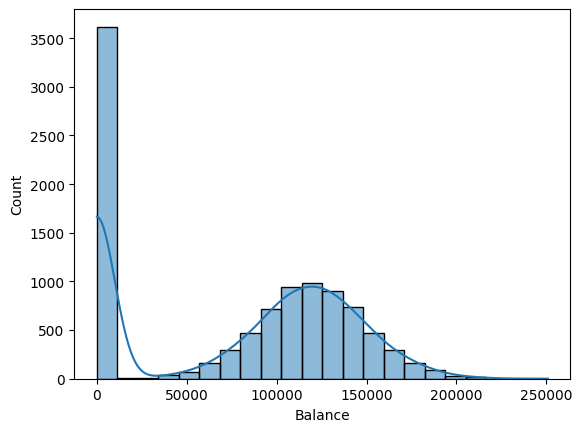

In [ ]:
sns.histplot(df['Balance'],kde=True)

In [ ]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [ ]:
# df['CreditScore_level'] = np.where(
#     df['CreditScore'] < 580, 0,
#     np.where(df['CreditScore'] < 670, 1, 2)
# )


In [ ]:
df['Geo_encoded'] = np.where(
    df['Geography'] == 'France', 3,
    np.where(df['Geography'] == 'Germany', 2, 1)
)

In [ ]:
df['Gender'] = (df['Gender'] == 'Male').astype(int)


In [ ]:
# df['Age'] = np.log(df['Age']).round(2)

In [ ]:
# df['HasBalance'] = np.where(df['Balance'] > 0, 1, 0)

# df['Engagement_score_HasBalance'] = df['HasBalance'] + df['IsActiveMember'] + (df['NumOfProducts']>1).astype(int)

df['Engagement_score'] = df['IsActiveMember'] + (df['NumOfProducts']>1).astype(int)

df['Mamber_Score'] = df['Tenure'] + df['NumOfProducts'] + df['HasCrCard'] + df['IsActiveMember']

In [ ]:
df = df.drop(columns=['Geography'],axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_encoded,Engagement_score,Mamber_Score
0,619,0,42,2,0.00,1,1,1,101348.88,1,3,1,5
1,608,0,41,1,83807.86,1,0,1,112542.58,0,1,1,3
2,502,0,42,8,159660.80,3,1,0,113931.57,1,3,1,12
3,699,0,39,1,0.00,2,0,0,93826.63,0,3,1,3
4,850,0,43,2,125510.82,1,1,1,79084.10,0,1,1,5


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score,confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [ ]:
X = df.drop('Exited', axis=1)
y = df['Exited']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


RandomForest Accuracy: 0.861
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1593
           1       0.82      0.40      0.54       407

    accuracy                           0.86      2000
   macro avg       0.84      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000

[[1558   35]
 [ 243  164]]
ROC AUC: 0.8597919953852158


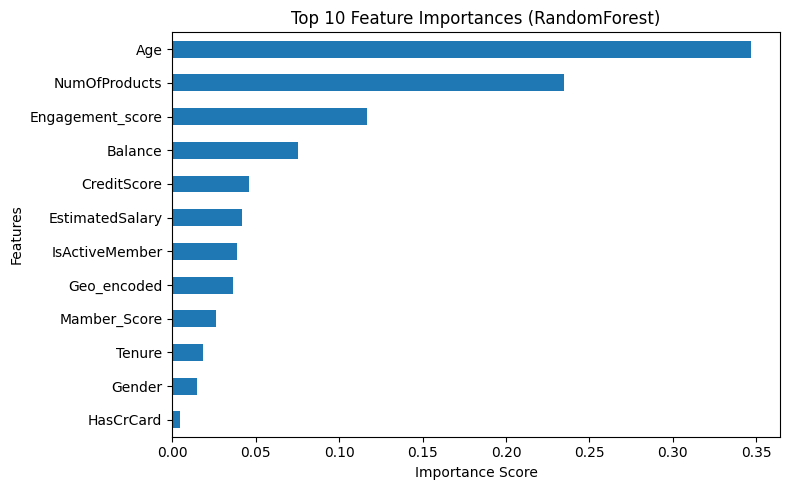

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1593
           1       0.58      0.64      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.84      2000

[[1405  188]
 [ 147  260]]
XGBoost Accuracy: 0.8705
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.48      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

[[1544   49]
 [ 210  197]]
ROC AUC: 0.8578347222415019


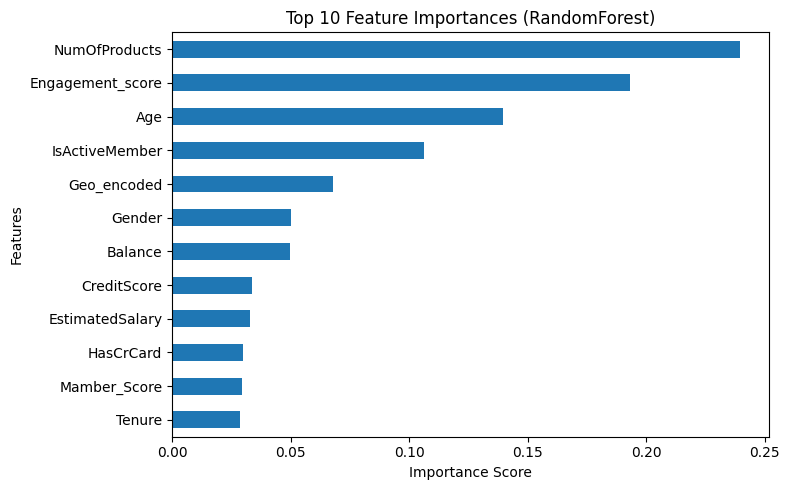

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("RandomForest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))

print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

import matplotlib.pyplot as plt

# Take top 10 features
rf_imp = pd.Series(rf.feature_importances_, index=X.columns)\
            .sort_values(ascending=False)


plt.figure(figsize=(8, 5))
rf_imp.sort_values().plot(kind='barh')

plt.title('Top 10 Feature Importances (RandomForest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')

plt.tight_layout()
plt.show()



xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))
xgb_imp = pd.Series(xgb.feature_importances_, index=X.columns)\
             .sort_values(ascending=False)


plt.figure(figsize=(8, 5))
xgb_imp.sort_values().plot(kind='barh')

plt.title('Top 10 Feature Importances (RandomForest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

In [ ]:
# # Step 1: get probabilities
y_proba = xgb.predict_proba(X_test)[:, 1]

# # Step 2: apply custom threshold
# threshold = 0.35
# y_pred = (y_proba >= threshold).astype(int)
# from sklearn.metrics import classification_report, confusion_matrix

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

for t in [0.30,0.35,0.4, 0.5,0.6,0.7]:
    y_pred = (y_proba >= t).astype(int)
    print(f"Threshold: {t}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))



Threshold: 0.3
[[1405  188]
 [ 147  260]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1593
           1       0.58      0.64      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.84      2000

Threshold: 0.35
[[1448  145]
 [ 160  247]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.63      0.61      0.62       407

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.85      0.85      0.85      2000

Threshold: 0.4
[[1482  111]
 [ 178  229]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.67      0.56      0.61       407

    accuracy                           0.86      2000
 

In [ ]:
# XGBoost Accuracy: 0.8705 ## Member_Score
#               precision    recall  f1-score   support

#            0       0.88      0.97      0.92      1593
#            1       0.80      0.48      0.60       407

#     accuracy                           0.87      2000
#    macro avg       0.84      0.73      0.76      2000
# weighted avg       0.86      0.87      0.86      2000

# [[1544   49]
#  [ 210  197]]
# ROC AUC: 0.8578347222415019


# XGBoost Accuracy: 0.8685 ## drop Engagement_score
#               precision    recall  f1-score   support

#            0       0.88      0.96      0.92      1593
#            1       0.78      0.49      0.60       407

#     accuracy                           0.87      2000
#    macro avg       0.83      0.73      0.76      2000
# weighted avg       0.86      0.87      0.86      2000

# [[1537   56]
#  [ 207  200]]
# ROC AUC: 0.8578362646159258


# Threshold: 0.35
# [[1452  141]
#  [ 156  251]]
#               precision    recall  f1-score   support

#            0       0.90      0.91      0.91      1593
#            1       0.64      0.62      0.63       407

#     accuracy                           0.85      2000
#    macro avg       0.77      0.76      0.77      2000
# weighted avg       0.85      0.85      0.85      2000

# Threshold: 0.3
# [[1405  188]
#  [ 147  260]]
#               precision    recall  f1-score   support

#            0       0.91      0.88      0.89      1593
#            1       0.58      0.64      0.61       407

#     accuracy                           0.83      2000
#    macro avg       0.74      0.76      0.75      2000
# weighted avg       0.84      0.83      0.84      2000

    1 → Churn করেছে (close)

    0 → এখনও আছে

    [[TN  FP]

    [FN  TP]]

FP (False Positive) → model বলেছে churn, কিন্তু গ্রাহক আসলে loyal

FN (False Negative) → model বলেছে loyal, কিন্তু গ্রাহক আসলে churn

TP (True Positive) → correctly predicted churn

TN (True Negative) → correctly predicted loyal

Business perspective:

FN = expensive, miss করলে বড় ক্ষতি

FP = less expensive, minor loss


| Term                | Meaning                                                 |
| ------------------- | ------------------------------------------------------- |
| FP (False Positive) | Model predicted churn, কিন্তু গ্রাহক আসলে **non-churn** |
| FN (False Negative) | Model predicted non-churn, কিন্তু গ্রাহক আসলে **churn** |


| Step | What to do                                                               |
| ---- | ------------------------------------------------------------------------ |
| 1    | Assign cost to FP and FN (example: FP=50, FN=500)                        |
| 2    | Calculate total cost = FN×FN_cost + FP×FP_cost                           |
| 3    | Sweep thresholds (0.1–0.9) and find threshold with **lowest total cost** |
| 4    | Use that threshold in production                                         |


  “Churn prediction-এ accuracy সবচেয়ে গুরুত্বপূর্ণ না। সবচেয়ে গুরুত্বপূর্ণ হলো churn customer miss না করা। তাই আমি business cost অনুযায়ী threshold কমিয়েছি। Threshold 0.30-এ recall সবচেয়ে বেশি (64%) এবং false negative সবচেয়ে কম, ফলে overall business loss minimum হয়।”


  “In churn prediction, missing a churn customer (FN) is much more costly than contacting a loyal customer (FP). Therefore, I optimize the model to minimize FN, even if FP increases slightly, because that maximizes business benefit.”

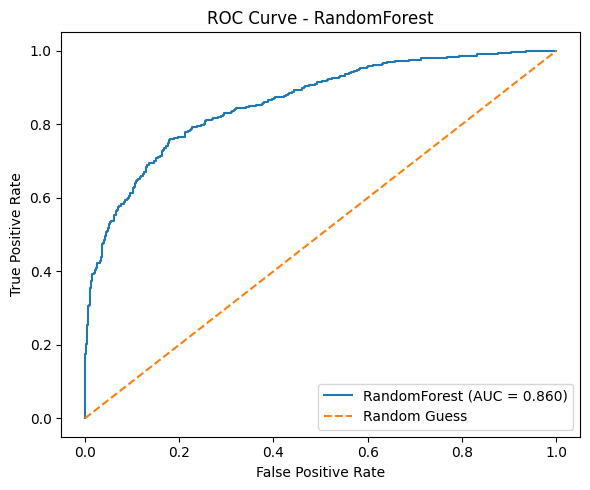

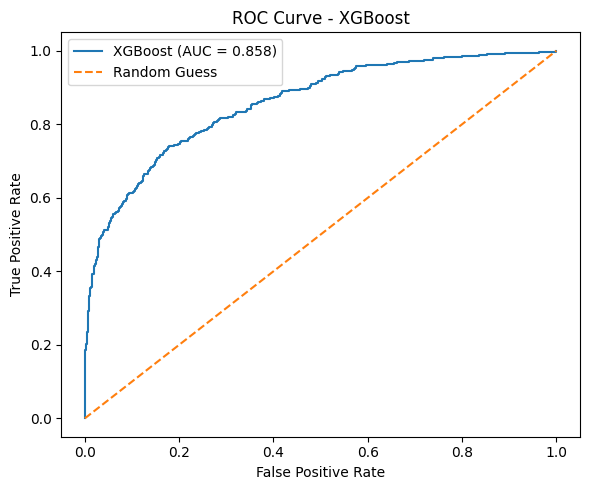

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# predicted probabilities
rf_probs = rf.predict_proba(X_test)[:, 1]

# ROC values
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
auc_score = roc_auc_score(y_test, rf_probs)

# plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'RandomForest (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest')
plt.legend()
plt.tight_layout()
plt.show()


from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# predicted probabilities
xgb_pred = xgb.predict_proba(X_test)[:, 1]

# ROC values
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred)
auc_score = roc_auc_score(y_test, xgb_pred)

# plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


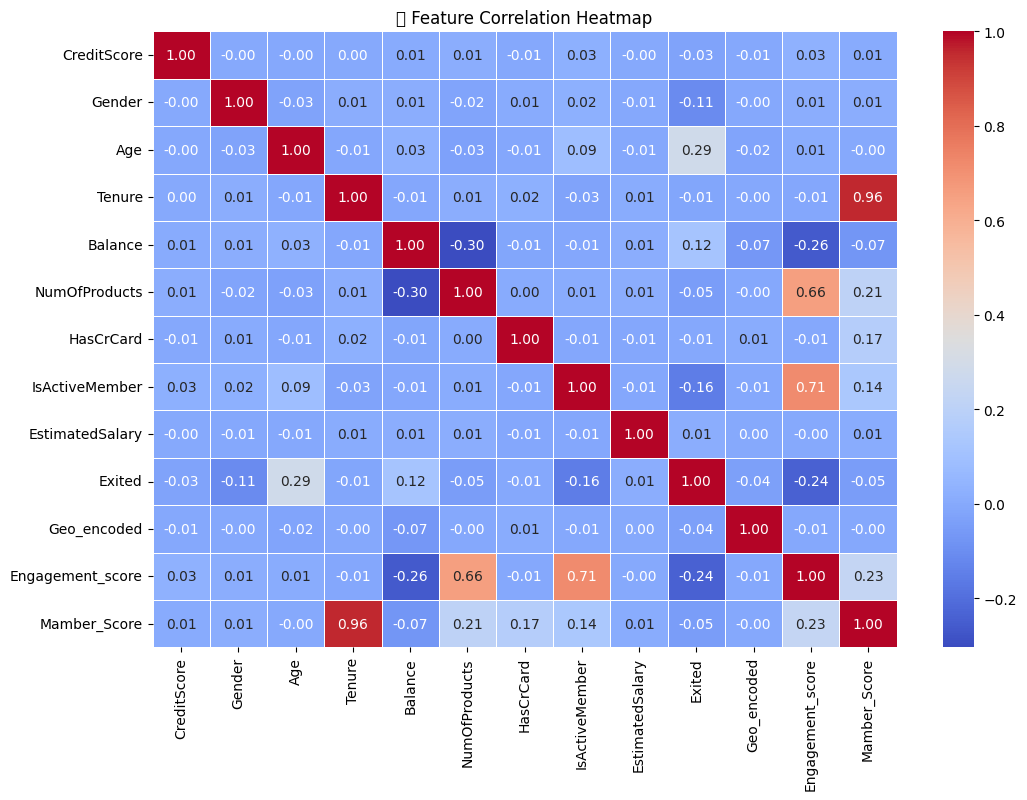

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("📊 Feature Correlation Heatmap")
plt.show()


## Auto-find Best Threshold

`Total Cost = FN × Cost_FN + FP × Cost_FP`


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# business costs
COST_FN = 500   # missed churn
COST_FP = 50    # unnecessary retention action

best_threshold = None
min_cost = float('inf')

results = []

# try thresholds from 0.05 to 0.95
# for threshold in np.arange(0.05, 0.95,0.35):
for threshold in [0.05, 0.95, 0.05,0.35,0.4, 0.5,0.6,0.7]:
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    total_cost = fn * COST_FN + fp * COST_FP

    results.append((threshold, total_cost, fn, fp))

    if total_cost < min_cost:
        min_cost = total_cost
        best_threshold = threshold


    # print(f" Find Threshold: {results}")
    # print(f" Minimum Business Cost: {min_cost}")


print(f"✅ Best Threshold: {best_threshold}")
print(f"💰 Minimum Business Cost: {min_cost}")


✅ Best Threshold: 0.05
💰 Minimum Business Cost: 55300


## demo code

In [ ]:
print("Tanvir")

Tanvir


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/Churn_Modelling.csv")

df = df.drop(columns=['RowNumber','CustomerId','Surname'],axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:

df['Geo_encoded'] = np.where(
    df['Geography'] == 'France', 3,
    np.where(df['Geography'] == 'Germany', 2, 1)
)
# df = pd.get_dummies(data=df, columns=['Geography'])


df['Gender'] = (df['Gender'] == 'Male').astype(int)

# df['Engagement_score'] = df['IsActiveMember'] + (df['NumOfProducts']>1).astype(int)

# df['Mamber_Score'] = df['Tenure'] + df['NumOfProducts'] + df['HasCrCard'] + df['IsActiveMember']

df = df.drop(columns=['Geography'],axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_encoded
0,619,0,42,2,0.00,1,1,1,101348.88,1,3
1,608,0,41,1,83807.86,1,0,1,112542.58,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,3
3,699,0,39,1,0.00,2,0,0,93826.63,0,3
4,850,0,43,2,125510.82,1,1,1,79084.10,0,1


In [ ]:
# df['BalanceSalaryRatio'] = df.Balance/df.EstimatedSalary
# sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df)
# plt.ylim(-1, 5)

# df['TenureByAge'] = df.Tenure/(df.Age)
# sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df)
# plt.ylim(-1, 1)
# plt.show()

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score,confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
# rf_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
rf_pred = (y_proba >= 0.3).astype(int)

# print("RandomForest Accuracy:", accuracy_score(y_test, rf_pred))
# print(classification_report(y_test, rf_pred))
# print(confusion_matrix(y_test, rf_pred))
# print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


xgb = XGBClassifier(
    n_estimators=350,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='binary:logistic',
    eval_metric='logloss',
    early_stopping_rounds=50,
    random_state=42
)

xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False)

xgb_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("Predict Proba*******************")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("Best n_estimators:", xgb.best_iteration)
print(classification_report(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))
xgb_imp = pd.Series(xgb.feature_importances_, index=X.columns)\
             .sort_values(ascending=False)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 5))
# xgb_imp.sort_values().plot(kind='barh')

# plt.title('Top 10 Feature Importances (XGBoost)')
# plt.xlabel('Importance Score')
# plt.ylabel('Features')

# plt.tight_layout()
# plt.show()

XGBoost Accuracy: 0.8475
Predict Proba*******************
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.62      0.67      0.64       407

    accuracy                           0.85      2000
   macro avg       0.76      0.78      0.77      2000
weighted avg       0.85      0.85      0.85      2000

[[1424  169]
 [ 136  271]]
XGBoost Accuracy: 0.868
Best n_estimators: 168
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.47      0.59       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000

[[1543   50]
 [ 214  193]]
ROC AUC: 0.8638407282475078


In [ ]:

for t in [0.30,0.35,0.4]:
    y_pred = (y_proba >= t).astype(int)
    print(f"Threshold: {t}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))



Threshold: 0.3
[[1424  169]
 [ 136  271]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.62      0.67      0.64       407

    accuracy                           0.85      2000
   macro avg       0.76      0.78      0.77      2000
weighted avg       0.85      0.85      0.85      2000

Threshold: 0.35
[[1466  127]
 [ 156  251]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1593
           1       0.66      0.62      0.64       407

    accuracy                           0.86      2000
   macro avg       0.78      0.77      0.78      2000
weighted avg       0.86      0.86      0.86      2000

Threshold: 0.4
[[1493  100]
 [ 172  235]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1593
           1       0.70      0.58      0.63       407

    accuracy                           0.86      2000
 

In [ ]:
df.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Geo_encoded'],
      dtype='object')

In [ ]:
# XGBoost Accuracy: 0.8455  ## Mamber_Score

# Predict Proba*******************
#               precision    recall  f1-score   support

#            0       0.91      0.90      0.90      1593
#            1       0.61      0.65      0.63       407

#     accuracy                           0.85      2000
#    macro avg       0.76      0.77      0.77      2000
# weighted avg       0.85      0.85      0.85      2000
# [[1426  167]
#  [ 142  265]]

# XGBoost Accuracy: 0.8425 ## Engagement_score
# Predict Proba*******************
#               precision    recall  f1-score   support

#            0       0.91      0.89      0.90      1593
#            1       0.60      0.66      0.63       407

#     accuracy                           0.84      2000
#    macro avg       0.76      0.77      0.76      2000
# weighted avg       0.85      0.84      0.84      2000

# [[1418  175]
#  [ 140  267]]



# Threshold: 0.3
# [[1405  188]
#  [ 147  260]]
#               precision    recall  f1-score   support

#            0       0.91      0.88      0.89      1593
#            1       0.58      0.64      0.61       407

#     accuracy                           0.83      2000
#    macro avg       0.74      0.76      0.75      2000
# weighted avg       0.84      0.83      0.84      2000

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


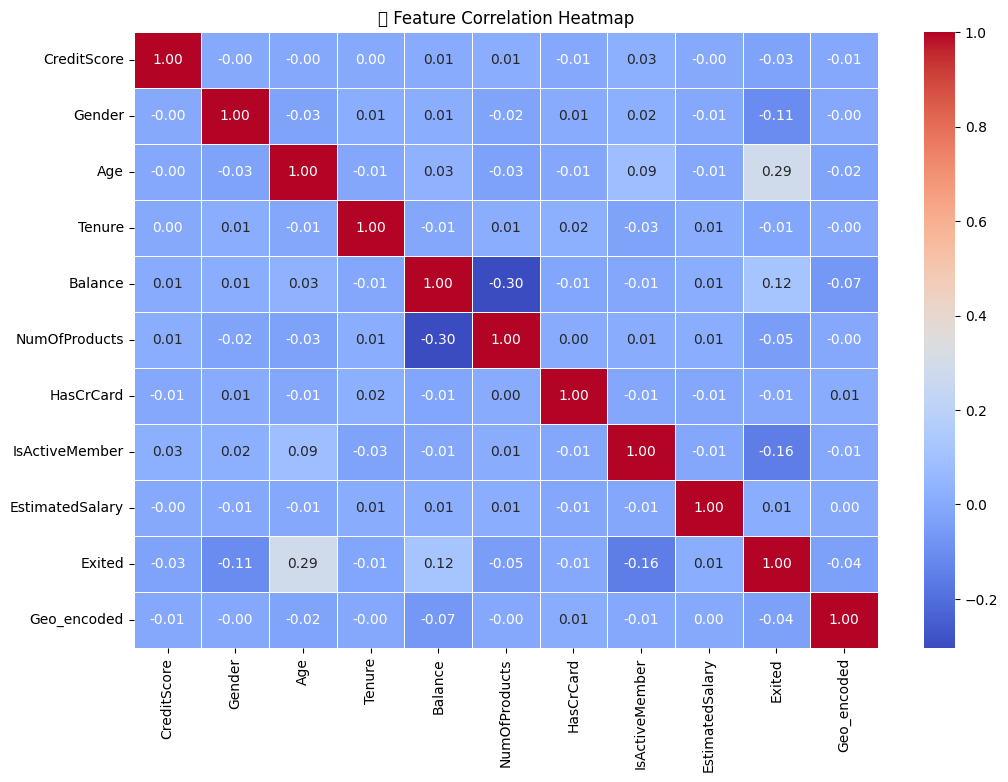

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("📊 Feature Correlation Heatmap")
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict


{0: np.float64(0.6279434850863422), 1: np.float64(2.4539877300613497)}

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

model.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    batch_size=32
)



Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6147 - loss: 0.6767 - precision: 0.2398 - recall: 0.4378 - val_accuracy: 0.6369 - val_loss: 0.6123 - val_precision: 0.3210 - val_recall: 0.7312
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6909 - loss: 0.5614 - precision: 0.3649 - recall: 0.7613 - val_accuracy: 0.6812 - val_loss: 0.5821 - val_precision: 0.3627 - val_recall: 0.7844
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7080 - loss: 0.5395 - precision: 0.3931 - recall: 0.7769 - val_accuracy: 0.7019 - val_loss: 0.5471 - val_precision: 0.3816 - val_recall: 0.7906
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7303 - loss: 0.5242 - precision: 0.4097 - recall: 0.7630 - val_accuracy: 0.7312 - val_loss: 0.5098 - val_precision: 0.4098 - val_recall: 0.7812
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7396 - loss: 0.4876 - precision: 0.4110 - recall: 0.7612 - val_accuracy: 0.7444 - val_loss: 0.4860 - 

In [ ]:
y_proba = model.predict(X_test_scaled).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", roc_auc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[1313  280]
 [ 111  296]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1593
           1       0.51      0.73      0.60       407

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.80      0.82      2000

ROC AUC: 0.8551633297396011


In [ ]:
for t in [0.30,0.35,0.4,0.5,0.6]:
    y_pred = (y_proba >= t).astype(int)
    print(f"Threshold: {t}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Threshold: 0.3
[[1074  519]
 [  67  340]]
              precision    recall  f1-score   support

           0       0.94      0.67      0.79      1593
           1       0.40      0.84      0.54       407

    accuracy                           0.71      2000
   macro avg       0.67      0.75      0.66      2000
weighted avg       0.83      0.71      0.74      2000

Threshold: 0.35
[[1144  449]
 [  80  327]]
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1593
           1       0.42      0.80      0.55       407

    accuracy                           0.74      2000
   macro avg       0.68      0.76      0.68      2000
weighted avg       0.83      0.74      0.76      2000

Threshold: 0.4
[[1205  388]
 [  86  321]]
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1593
           1       0.45      0.79      0.58       407

    accuracy                           0.76      2000
 

In [ ]:
# Threshold: 0.3
# [[1424  169]
#  [ 136  271]]
#               precision    recall  f1-score   support

#            0       0.91      0.89      0.90      1593
#            1       0.62      0.67      0.64       407

#     accuracy                           0.85      2000
#    macro avg       0.76      0.78      0.77      2000
# weighted avg       0.85      0.85      0.85      2000

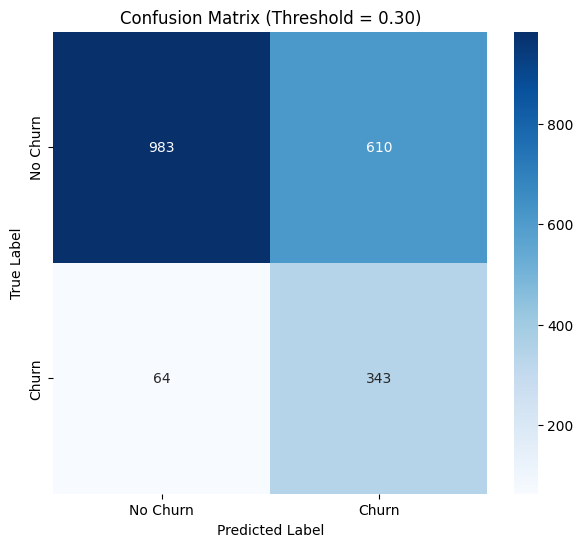

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

cm = tf.math.confusion_matrix(
    labels=y_test,
    predictions=y_pred
).numpy()

plt.figure(figsize=(7,6))
sn.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Churn', 'Churn'],
    yticklabels=['No Churn', 'Churn']
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Threshold = 0.30)')
plt.show()


## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train, y_train
)
print(y_train.value_counts())
print(y_train_smote.value_counts())
print('*'*50)
# print(X_train.value_counts())
# print(X_train_smote.value_counts())

Exited
0    6370
1    1630
Name: count, dtype: int64
Exited
1    6370
0    6370
Name: count, dtype: int64
**************************************************


In [ ]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb = XGBClassifier(
    n_estimators=350,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=50,
    random_state=42
)

xgb.fit(X_train_smote, y_train_smote,
        eval_set=[(X_test, y_test)],
        verbose=False)

y_pred = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

XGBoost Accuracy: 0.715
[[1095  498]
 [  72  335]]
              precision    recall  f1-score   support

           0       0.94      0.69      0.79      1593
           1       0.40      0.82      0.54       407

    accuracy                           0.71      2000
   macro avg       0.67      0.76      0.67      2000
weighted avg       0.83      0.71      0.74      2000



In [ ]:
y_proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)
for t in [0.30,0.35,0.4,0.5]:
    y_pred = (y_proba >= t).astype(int)
    print(f"Threshold: {t}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Threshold: 0.3
[[825 768]
 [ 38 369]]
              precision    recall  f1-score   support

           0       0.96      0.52      0.67      1593
           1       0.32      0.91      0.48       407

    accuracy                           0.60      2000
   macro avg       0.64      0.71      0.57      2000
weighted avg       0.83      0.60      0.63      2000

Threshold: 0.35
[[902 691]
 [ 43 364]]
              precision    recall  f1-score   support

           0       0.95      0.57      0.71      1593
           1       0.35      0.89      0.50       407

    accuracy                           0.63      2000
   macro avg       0.65      0.73      0.60      2000
weighted avg       0.83      0.63      0.67      2000

Threshold: 0.4
[[960 633]
 [ 53 354]]
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      1593
           1       0.36      0.87      0.51       407

    accuracy                           0.66      2000
   macro avg 

In [ ]:

# XGBoost Accuracy: 0.8475
# Predict Proba*******************
#               precision    recall  f1-score   support

#            0       0.91      0.89      0.90      1593
#            1       0.62      0.67      0.64       407

#     accuracy                           0.85      2000
#    macro avg       0.76      0.78      0.77      2000
# weighted avg       0.85      0.85      0.85      2000